## Amortized MCMC for toy distributions

Author: Chunyuan Li ( http://chunyuan.li/ ). 
Tensorflow implementation of 


(1) Gradient-based MCMC algorithm; 

(2) Adversarial and L2 loss based Amortized Algorithm: distill the knowledge of the MCMC dynamics into stochastic neural nets. 

(3) The adversarial loss is better metric than L2 in measuing distribution discrepency for amortization 

https://openreview.net/pdf?id=S1eZGHkDM


Please contact me if there is any issue.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import pdb
import matplotlib
# import some stuff
from __future__ import division, print_function

from scipy.stats import gaussian_kde

import os
import pandas as pd
import seaborn as sns

# set gpu device - only important for multi gpu systems
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import tensorflow as tf

rng = np.random.RandomState()
np.random.seed(44)

/home/kd/anaconda3/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Test toy distributions:

In [2]:

def w1(z):
    return tf.sin(2.*np.pi*z[0]/4.)
def w2(z):
    return 3.*tf.exp(-.5*(((z[0]-1.)/.6))**2)
def w3(z):
    return 3.*(1+tf.exp(-(z[0]-1.)/.3))**-1
def pot0(z):
    z = tf.transpose(z)
    return .5*((tf.norm(z, ord=2, axis=0)-0.)/.4)**2 - tf.log(tf.exp(-.5*((z[0]-0.)/.8)**2) )
def pot1(z):
    z = tf.transpose(z)
    return .5*((tf.norm(z, ord=2, axis=0)-2.)/.4)**2 - tf.log(tf.exp(-.5*((z[0]-2.)/.6)**2) + tf.exp(-.5*((z[0]+2.)/.6)**2))

def pot1_hard(z):
    z = tf.transpose(z)
    return .5*((tf.norm(z, ord=2, axis=0)-3.)/.4)**2 - tf.log(tf.exp(-.5*((z[0]-3.)/.6)**2) + tf.exp(-.5*((z[0]+3.)/.6)**2))


def pot2(z):
    z = tf.transpose(z)
    return .5*((z[1]-w1(z))/.4)**2
def pot3(z):
    z = tf.transpose(z)
    return -tf.log(tf.exp(-.5*((z[1]-w1(z))/.35)**2) + tf.exp(-.5*((z[1]-w1(z)+w2(z))/.35)**2))
def pot4(z):
    z = tf.transpose(z)
    return -tf.log(tf.exp(-.5*((z[1]-w1(z))/.4)**2) + tf.exp(-.5*((z[1]-w1(z)+w3(z))/.35)**2))

In [3]:
def evaluate_bivariate(range, npoints):
    """Evaluate (possibly unnormalized) pdf over a meshgrid."""
    side = np.linspace(range[0], range[1], npoints)
    z1, z2 = np.meshgrid(side, side)
    zv = np.hstack([z1.reshape(-1, 1), z2.reshape(-1, 1)])
    
    return z1, z2, zv

The MCMC update rule:  $x \leftarrow x + lr * gradient + lr * noise$, where $noise \sim N(0,1)$

In [66]:
dtype = tf.float32
num_particles=128*4
num_latent = 1
lr = 0.001
alpha=.9
fudge_factor = 1e-6
num_iter = 50
range_limit = [-1,1]
npoints_plot=50

Text(0.5,1,u'Target distribution: $u(z)$')

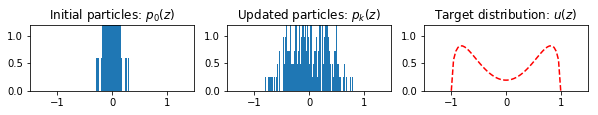

In [71]:

z  = tf.placeholder(tf.float32, [num_particles, num_latent])
prob = tf.maximum( (1- (z/2.0 + 0.5))**(0.5) * (z/2.0 + 0.5)**(5) + (1- (z/2.0 + 0.5))**(5) * (z/2.0 + 0.5)**(0.5), 1e-3 )
f = tf.log(prob)
log_p_grad = tf.squeeze(tf.gradients(f, z), axis=[0])

grad_theta = log_p_grad 


z_np = -np.random.randn(num_particles, num_latent)*.1

fig, _ = plt.subplots(figsize=(10, 5))
ax=plt.subplot(1,3,1, aspect='equal')

plt.hist(z_np[:,0],200, normed=1)  
plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.2]); ax.set_title('Initial particles: $p_0(z)$')

with tf.Session() as s:
    for i in xrange(num_iter):
        grad_theta_ = s.run( grad_theta, feed_dict={z: z_np } )
        noise_sample = np.random.randn(num_particles, num_latent) * np.sqrt(lr)
        z_np = z_np + lr * grad_theta_ + noise_sample
        z_np[z_np>1.5]=0.9
        z_np[z_np<-1.5]=-0.9

ax=plt.subplot(1,3,2, aspect='equal')
plt.hist(z_np[:,0],200, normed=1)  
plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.2]); ax.set_title('Updated particles: $p_k(z)$')

# plot the Target distribution
z_pp  = tf.placeholder(tf.float32, [None, num_latent])

ax=plt.subplot(1,3,3, aspect='equal')
from scipy.stats import beta 
coords = np.linspace(range_limit[0], range_limit[1], npoints_plot)
plt.plot(coords, 0.25*(beta.pdf(coords/2.0 + 0.5, 6, 1.5) + beta.pdf(coords/2.0 + 0.5, 1.5, 6)), 'r--')

plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.2]); ax.set_title('Target distribution: $u(z)$')


In [150]:
np.save('samples_mcmc_constrained_teacher_2mode.npy', z_np)

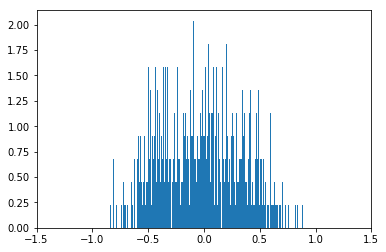

In [53]:
plt.hist(z_np[:,0],200, normed=1) 
plt.xlim([-1.5,1.5]);
plt.show()

### Adversarial-based Amortized MCMC

In [27]:
slim = tf.contrib.slim
ds = tf.contrib.distributions

In [72]:
""" parameters """
input_dim = 1
latent_dim = 1
eps_dim = 1
batch_size = num_particles

n_layer_disc = 2
n_hidden_disc = 256
n_layer_gen = 2
n_hidden_gen= 256
n_layer_inf = 2
n_hidden_inf= 256

Marginal distribution

In [30]:
""" Construct model and training ops """
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(batch_size, input_dim))
z = tf.placeholder(tf.float32, shape=(batch_size, latent_dim))

# decoder and encoder
p_x = generative_network(z, input_dim , n_layer_gen, n_hidden_gen, eps_dim)

gen_logit = disc_network(p_x, n_layers=n_layer_disc, n_hidden=n_hidden_disc)
gen_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(gen_logit), logits=gen_logit)

obs_logit = disc_network(x, n_layers=n_layer_disc, n_hidden=n_hidden_disc, reuse=True)
obs_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(gen_logit), logits=obs_logit)

disc_loss = tf.reduce_mean(  gen_loss ) + tf.reduce_mean( obs_loss)

rec_z = inference_network(p_x, latent_dim, n_layer_inf, n_hidden_inf, eps_dim )
cost_z = tf.reduce_mean(tf.pow(rec_z - z, 2))

gen_loss_x = tf.reduce_mean(  gen_logit ) 

gen_loss = 1.*gen_loss_x + 1.0*cost_z

qvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "inference")
pvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generative")
dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

opt = tf.train.AdamOptimizer(1e-3, beta1=0.5)
train_gen_op =  opt.minimize(gen_loss, var_list=qvars + pvars)
train_disc_op = opt.minimize(disc_loss, var_list=dvars)

Instructions for updating:
Use the `axis` argument instead


0
1
2
3
4
5
6
7
8
9


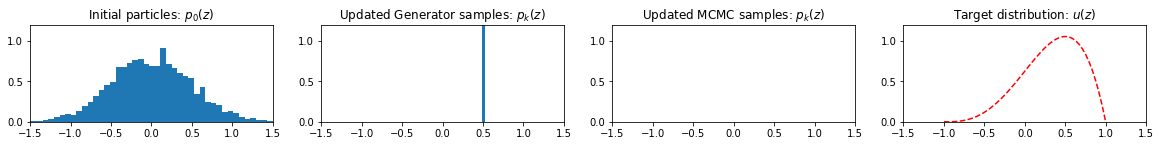

In [54]:
""" training """

x_target = tf.placeholder(tf.float32, [num_particles, num_latent])

prob = tf.maximum( (1- (z/2.0 + 0.5))**(0.5) * (z/2.0 + 0.5)**(5) + (1- (z/2.0 + 0.5))**(5) * (z/2.0 + 0.5)**(0.5), 1e-4 )
f = tf.log(prob)
log_p_grad = tf.squeeze(tf.gradients(f, x_target), axis=[0])

grad_theta = log_p_grad


# plot initial particle position
z_np = -np.random.randn(num_particles, num_latent)*0.5
fig, _ = plt.subplots(figsize=(20, 5))
ax=plt.subplot(1,4,1, aspect='equal')
plt.hist(z_np[:,0],50, normed=1)  
plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.2]); ax.set_title('Initial particles: $p_0(z)$')

num_iter = 10
with tf.Session() as s:
    s.run(tf.global_variables_initializer())


    for i in range(num_iter):
        print(i)
        
        # generate current samples to update
        for _ in range(1):
            zmb = np.random.normal(size=(num_particles, 1))
            x_gen_np = s.run( p_x, feed_dict={z:zmb}) 

        # update target particle via MCMC
        x_target_np = x_gen_np
        for _ in range(600):
            grad_theta_ = s.run( grad_theta, feed_dict={x_target: x_target_np } )
            # print(grad_theta_)
            noise_sample = np.random.randn(num_particles, num_latent) * np.sqrt(lr)
            x_target_np = x_target_np + lr * grad_theta_
  
        for _ in range(200):            
            for _ in range(3):
                zmb = np.random.normal(size=(num_particles, 1))
                x_gen_np, f_g  = s.run([ p_x, train_gen_op], feed_dict={z:zmb})    

            # update discriminator
            for _ in range(1):
                f_d, _ = s.run([disc_loss, train_disc_op], feed_dict={x: x_target_np, z:zmb})    

    # plot generator's particle
    ax=plt.subplot(1,4,2, aspect='equal')
    plt.hist(x_gen_np[:,0],2000, normed=1)  
    plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.2]); ax.set_title('Updated Generator samples: $p_k(z)$')
  
    
    
    # plot SVGD's particle
    ax=plt.subplot(1,4,3, aspect='equal')
    plt.hist(x_target_np[:,0],2000, normed=1)  
    plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.2]); ax.set_title('Updated MCMC samples: $p_k(z)$')

    # plot the Target distribution
    ax=plt.subplot(1,4,4, aspect='equal'
    from scipy.stats import beta 
    coords = np.linspace(range_limit[0], range_limit[1], npoints_plot)
    plt.plot(coords,  0.25*(beta.pdf(coords/2.0 + 0.5, 6, 1.5) + beta.pdf(coords/2.0 + 0.5, 1.5, 6)), 'r--')

    plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.2]); ax.set_title('Target distribution: $u(z)$')
    plt.show()
    
    # generate samples to visualize
    x_gen = []
    for _ in range(10):
        zmb = np.random.normal(size=(num_particles, 1))
        x_gen_np = s.run( p_x, feed_dict={z:zmb}) 
        x_gen.append(x_gen_np)
    x_gen = np.concatenate(x_gen, 0)
    
    np.savez('samples_mcmc_constrained.npz', nn_samples=x_gen, svgd_samples=x_target_np)
    
    s.close()

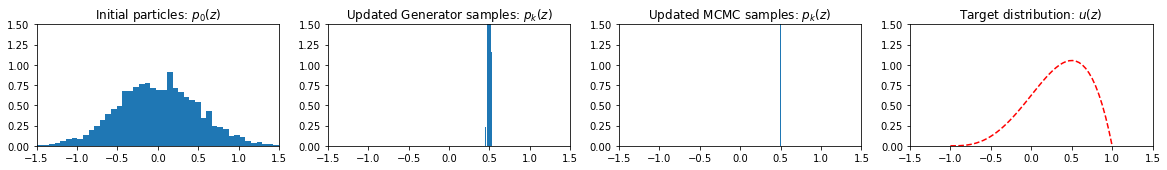

In [57]:


fig, _ = plt.subplots(figsize=(20, 5))
ax=plt.subplot(1,4,1, aspect='equal')
plt.hist(z_np[:,0],50, normed=1)  
plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.5]); ax.set_title('Initial particles: $p_0(z)$')


ax=plt.subplot(1,4,2, aspect='equal')
plt.hist(x_gen_np[:,0],50, normed=1)  
plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.5]); ax.set_title('Updated Generator samples: $p_k(z)$')

# plot SVGD's particle
ax=plt.subplot(1,4,3, aspect='equal')
plt.hist(x_target_np[:,0],50, normed=1)  
plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.5]); ax.set_title('Updated MCMC samples: $p_k(z)$')


# plot the Target distribution
ax=plt.subplot(1,4,4, aspect='equal')
from scipy.stats import beta 
coords = np.linspace(range_limit[0], range_limit[1], npoints_plot)
plt.plot(coords, beta.pdf(coords/2.0 + 0.5, 4, 2)/2.0, 'r--')

plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.5]); ax.set_title('Target distribution: $u(z)$')
plt.show()
    